In [1]:
import pandas as pd 
df=pd.read_csv("train.csv")
df
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
df.replace('?', pd.NA, inplace=True)
n_col = df.select_dtypes(include=['number']).columns
cat_col = df.select_dtypes(exclude=['number']).columns

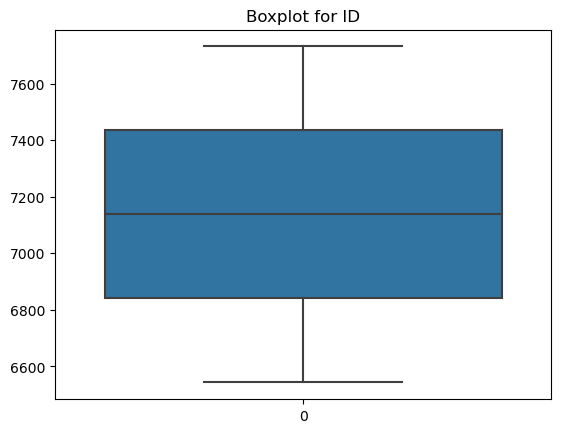

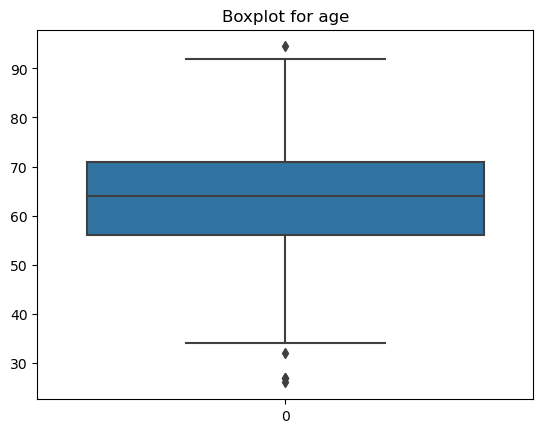

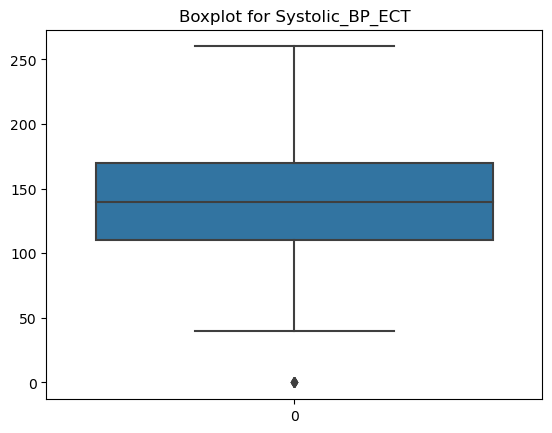

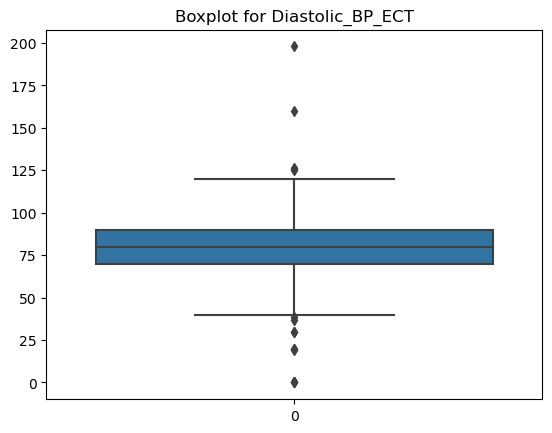

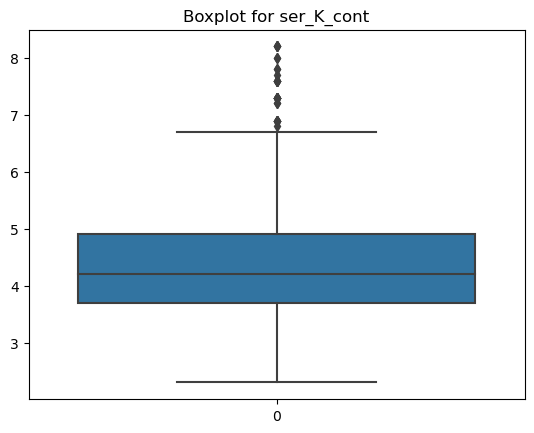

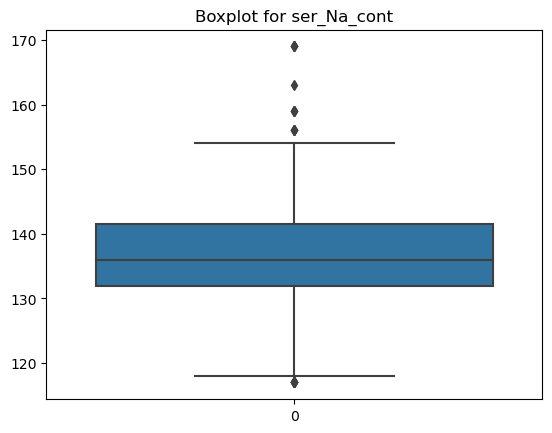

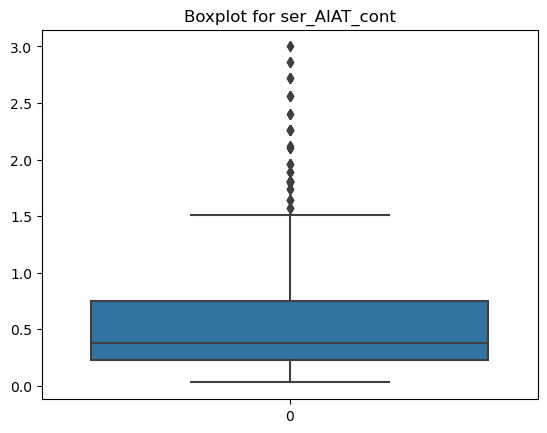

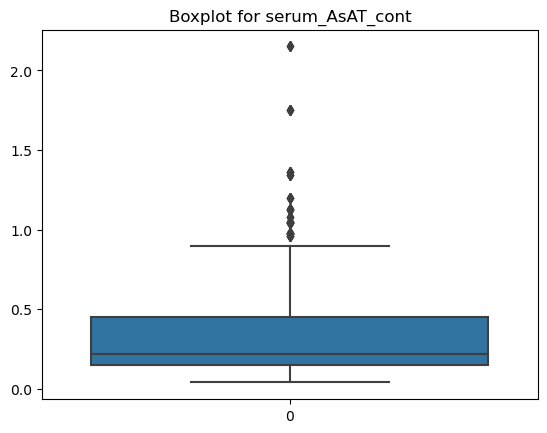

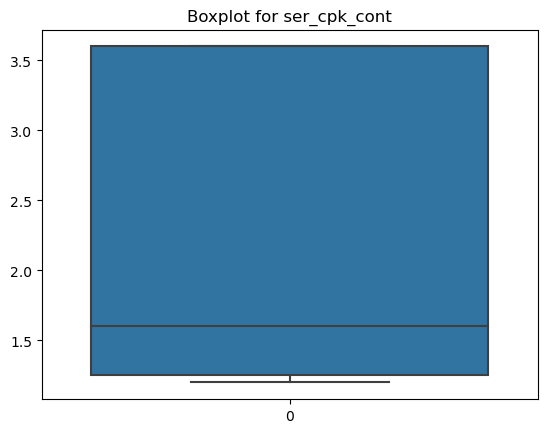

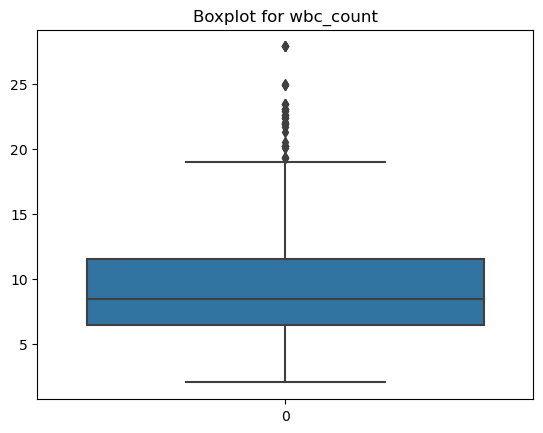

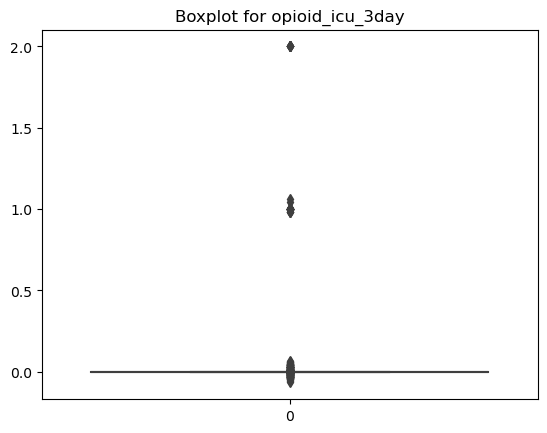

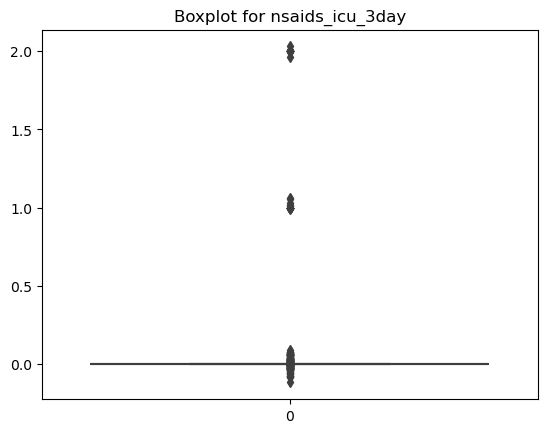

In [2]:
import matplotlib.pyplot as plt 
import seaborn as sns
for i in n_col:
    sns.boxplot(df[i])
    plt.title(f'Boxplot for {i}')
    plt.show()




In [3]:
df = df.drop('ser_K_cont', axis=1)
df = df.drop('Diastolic_BP_ECT', axis=1)
df = df.drop('opioid_icu_3day', axis=1)
df = df.drop('nsaids_icu_3day', axis=1)


In [4]:
df.select_dtypes(include=['number']).columns


Index(['ID', 'age', 'Systolic_BP_ECT', 'ser_Na_cont', 'ser_AIAT_cont',
       'serum_AsAT_cont', 'ser_cpk_cont', 'wbc_count'],
      dtype='object')

In [5]:
import numpy as np
n_col_modified=['ser_Na_cont','ser_AIAT_cont','serum_AsAT_cont','wbc_count']

for col in n_col_modified:
    median_val = df[col].median()
    iqr = df[col].quantile(0.75) - df[col].quantile(0.25)
    threshold_upper = df[col].quantile(0.75) + 1.5 * iqr
    threshold_lower = df[col].quantile(0.25) - 1.5 * iqr
    
    outliers_upper = df[col] > threshold_upper
    outliers_lower = df[col] < threshold_lower
    df.loc[outliers_upper, col] = np.random.uniform(median_val, threshold_upper, size=outliers_upper.sum())
    df.loc[outliers_lower, col] = np.random.uniform(threshold_lower, median_val, size=outliers_lower.sum())


In [6]:
df.isnull().sum()

ID                                         0
age                                      250
sex                                      246
myocardial_infarctions_anamnesis           7
Exertional_angina_pectoris_anamnesis     200
FC_of_angina_pectoris                     92
Coronary_heart_disease(CHD)               52
Heredity_on_CHD                         1030
essential_hypertension                    49
Symptomatic_hypertension                  94
no_arterial_hypertension_duration        372
chronic_Heart_failure(HF)                 83
nr11                                     257
nr01                                     107
nr02                                     257
nr03                                      37
nr04                                      73
nr07                                      13
nr08                                      44
np01                                     116
np04                                      12
np05                                      95
np07      

In [7]:
n_c = df.select_dtypes(include=['number']).columns

for i in n_c:
    df[i]=df[i].fillna(df[i].mean())
df[n_c] = df[n_c].apply(lambda col: col.fillna(col.mean()))
df[cat_col] = df[cat_col].apply(lambda col: col.fillna(col.mode().iloc[0]))
from sklearn.preprocessing import LabelEncoder
le=LabelEncoder()
for i in cat_col:
    df[i]=le.fit_transform(df[i])


In [8]:
df.isnull().sum()

ID                                      0
age                                     0
sex                                     0
myocardial_infarctions_anamnesis        0
Exertional_angina_pectoris_anamnesis    0
FC_of_angina_pectoris                   0
Coronary_heart_disease(CHD)             0
Heredity_on_CHD                         0
essential_hypertension                  0
Symptomatic_hypertension                0
no_arterial_hypertension_duration       0
chronic_Heart_failure(HF)               0
nr11                                    0
nr01                                    0
nr02                                    0
nr03                                    0
nr04                                    0
nr07                                    0
nr08                                    0
np01                                    0
np04                                    0
np05                                    0
np07                                    0
np08                              

In [9]:
df.sex.value_counts()

1    803
0    387
Name: sex, dtype: int64

In [10]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, precision_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.regularizers import l2

selected_columns = ['atr_fib', 'supr_tach', 'ven_tach', 'ven_fib', 'th_d_av', 'pul_ede', 'myo_rup', 'dres_syn', 'ch_hf', 're_myin', 'p_inf_ang']

x= df.drop(columns=selected_columns + ['ID'])
y = df[selected_columns]

x_train,x_test,y_train,y_test=train_test_split(x,y,test_size=0.2,random_state=42)

scaler = StandardScaler()
x_train = scaler.fit_transform(x_train)
x_test = scaler.transform(x_test)

from tensorflow.keras.regularizers import l2

model = Sequential()
model.add(Dense(64, activation='relu', input_dim=x_train.shape[1], kernel_regularizer=l2(0.01)))
model.add(Dropout(0.5))  # Dropout layer to prevent overfitting
model.add(Dense(32, activation='relu', kernel_regularizer=l2(0.01)))
model.add(Dropout(0.5))  # Dropout layer to prevent overfitting
model.add(Dense(y_train.shape[1], activation='sigmoid', kernel_regularizer=l2(0.01)))

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

early_stopping = EarlyStopping(monitor='val_loss', patience=2, restore_best_weights=True)

history = model.fit(x_train, y_train, epochs=50, batch_size=32, validation_split=0.2, callbacks=[early_stopping])

y_pred = model.predict(x_test)

y_pred_binary = (y_pred > 0.5).astype(int)

accuracy = accuracy_score(y_test, y_pred_binary)
print("Accuracy:", accuracy)

Epoch 1/50
24/24 [==============================] - 2s 35ms/step - loss: 2.0438 - accuracy: 0.0696 - val_loss: 1.7603 - val_accuracy: 0.0524
Epoch 2/50
24/24 [==============================] - 0s 5ms/step - loss: 1.6813 - accuracy: 0.0815 - val_loss: 1.4941 - val_accuracy: 0.0419
Epoch 3/50
24/24 [==============================] - 0s 5ms/step - loss: 1.4308 - accuracy: 0.0618 - val_loss: 1.2679 - val_accuracy: 0.0314
Epoch 4/50
24/24 [==============================] - 0s 5ms/step - loss: 1.2169 - accuracy: 0.0657 - val_loss: 1.0819 - val_accuracy: 0.0366
Epoch 5/50
24/24 [==============================] - 0s 8ms/step - loss: 1.0437 - accuracy: 0.0802 - val_loss: 0.9359 - val_accuracy: 0.0419
Epoch 6/50
24/24 [==============================] - 0s 5ms/step - loss: 0.9045 - accuracy: 0.1196 - val_loss: 0.8210 - val_accuracy: 0.0471
Epoch 7/50
24/24 [==============================] - 0s 5ms/step - loss: 0.7966 - accuracy: 0.1091 - val_loss: 0.7283 - val_accuracy: 0.1099
Epoch 8/50
24/24 [=

## submit 

In [11]:
df2=pd.read_csv("test.csv")
df2.isnull().sum()
df2.replace('?',pd.NA,inplace=True)



In [12]:
df2 = df2.drop('ser_K_cont', axis=1)
df2 = df2.drop('Diastolic_BP_ECT', axis=1)
df2 = df2.drop('opioid_icu_3day', axis=1)
df2 = df2.drop('nsaids_icu_3day', axis=1)

In [13]:
for i in n_c:
    df2[i]=df2[i].fillna(df2[i].mean())
cat_col2 = df2.select_dtypes(exclude=['number']).columns
df2[n_c] = df2[n_c].apply(lambda col: col.fillna(col.mean()))
df2[cat_col2] = df2[cat_col2].apply(lambda col: col.fillna(col.mode().iloc[0]))
from sklearn.preprocessing import LabelEncoder
le=LabelEncoder()
for i in cat_col2:
    df2[i]=le.fit_transform(df2[i])

In [14]:
df2.isnull().sum()

ID                                      0
age                                     0
sex                                     0
myocardial_infarctions_anamnesis        0
Exertional_angina_pectoris_anamnesis    0
FC_of_angina_pectoris                   0
Coronary_heart_disease(CHD)             0
Heredity_on_CHD                         0
essential_hypertension                  0
Symptomatic_hypertension                0
no_arterial_hypertension_duration       0
chronic_Heart_failure(HF)               0
nr11                                    0
nr01                                    0
nr02                                    0
nr03                                    0
nr04                                    0
nr07                                    0
nr08                                    0
np01                                    0
np04                                    0
np05                                    0
np07                                    0
np08                              

In [15]:

Xtst= df2.drop('ID', axis=1)  
yp = model.predict(Xtst)
results_df = pd.DataFrame({'ID': df2['ID']})
for i, column in enumerate(y):
    results_df[column] = yp[:, i]
results_df.to_csv('dldropped.csv', index=False)


16/16 [==============================] - 0s 1ms/step
